In [193]:
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import numpy as np
from blimpy import read_header, Waterfall, Filterbank

import sys, os, glob
import csv

sys.path.append("../../../setigen/")
import setigen as stg

# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import keras
import tensorflow as tf

import numpy as np
import os, sys, errno

import csv
import codecs
import pickle

from training_classes import DataGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dir_name = '/datax/scratch/bbrzycki/training/training1/'
test_csv_fn = dir_name + 'test/test_labels.csv'
# validation_csv_fn = dir_name + 'train/validation_labels.csv'
model_fn = dir_name + 'models/model3.h5'
# history_fn = dir_name + 'models/model3_history'

In [4]:
inputs = []
info = {}
all_info = {}
labels=[]
with open(test_csv_fn, 'r') as f:
    reader = csv.reader(x.replace('\0', '') for x in f)
    for i, row in enumerate(reader):
        output_path, sig_num, sig_db, start_index, drift_rate, line_width, rfi_num, rfi_db, rfi_indices, rfi_widths = row
        label = int(sig_num) + int(rfi_num)
        labels.append(label)
        inputs.append(output_path)
        info[output_path] = sig_num, sig_db, rfi_num, rfi_db
        all_info[output_path] = output_path, sig_num, sig_db, start_index, drift_rate, line_width, rfi_num, rfi_db, rfi_indices, rfi_widths
        

In [5]:
np.mean(labels)

2.0

In [6]:
np.std(labels)

1.224744871391589

In [7]:
len(inputs)

20000

In [16]:
# Design model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.load_weights(model_fn)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 1022, 32)      320       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 1022, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 1020, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 1020, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 510, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 508, 32)       9248      
_________________________________________________________________
activation_8 (Activation)    (None, 12, 508, 32)       0         
__________

In [10]:
keras.utils.plot_model(model, 'model3.png', show_shapes=True)

In [18]:
# from keras.backend import manual_variable_initialization 
# manual_variable_initialization(True)

# model = multi_gpu_model(model, gpus=2)
# model.load_weights(model_fn)

In [23]:
inputs[0]

'/datax/scratch/bbrzycki/training/training1/test/frame_0rfi_0sig_00db_0000.npy'

In [24]:
X = np.load(inputs[0]).reshape((1, 32, 1024, 1))
X.shape

(1, 32, 1024, 1)

In [26]:
X = np.load('/datax/scratch/bbrzycki/training/training1/test/frame_0rfi_1sig_20db_0000.npy').reshape((1, 32, 1024, 1))
X.shape

(1, 32, 1024, 1)

In [27]:
model.predict(X)

array([[-216671.62]], dtype=float32)

In [18]:
import pickle
with open(dir_name + 'models/model3_history', 'rb') as f:
    history = pickle.load(f)
    
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

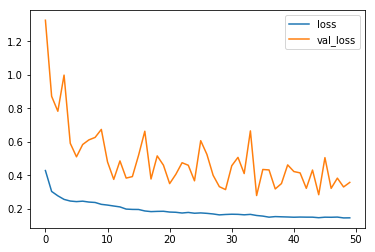

In [19]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [38]:
labels[inputs[0]]

0

In [59]:
index = 100
X = np.load(inputs[index]).reshape((1, 32, 1024, 1))
print(model.predict_classes(X)[0][0])
print(info[inputs[index]][0])

1
0


In [28]:
predictions = []
for input_fn in inputs:
    sig_num, sig_db, rfi_num, rfi_db = info[input_fn]
    
    X = np.load(input_fn).reshape((1, 32, 1024, 1))
    prediction = model.predict(X)[0][0]
    
    predictions.append(prediction)
predictions = np.array(predictions)
predictions

array([-169735.6  , -209013.17 , -216935.6  , ...,  -86454.734,
       -310836.78 ,  -82898.195], dtype=float32)

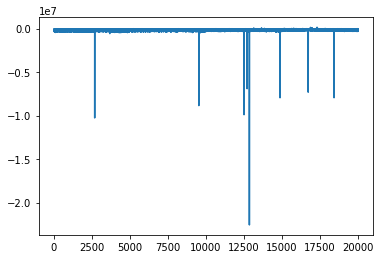

In [29]:
plt.plot(predictions)
plt.show()

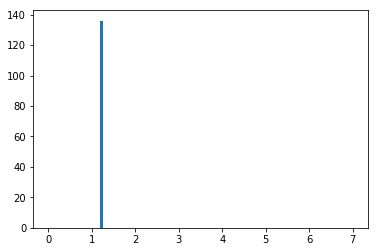

In [32]:
plt.hist(predictions, bins=100, range=(0, 7))
plt.show()

In [82]:
rfi = np.zeros((4, 5))
for input_fn in inputs:
    sig_num, sig_db, rfi_num, rfi_db = info[input_fn]
    
    X = np.load(input_fn).reshape((1, 32, 1024, 1))
    predicted_sig_num = model.predict_classes(X)[0][0]
    
    if int(sig_num) * predicted_sig_num > 1:
        print(input_fn, int(sig_num) * predicted_sig_num)
        break
        
    if int(sig_num) == predicted_sig_num:
        rfi[int(rfi_num), int(sig_db) // 5] += 1
#     print(int(rfi_num), int(sig_db) // 5, int(sig_num) * predicted_sig_num)
    
rfi /= 1000

# for percent
rfi *= 100

In [83]:
rfi

array([[0.5  , 0.5  , 0.5  , 0.492, 0.39 ],
       [0.486, 0.514, 0.496, 0.509, 0.533],
       [0.5  , 0.498, 0.512, 0.49 , 0.509],
       [0.483, 0.497, 0.514, 0.521, 0.484]])

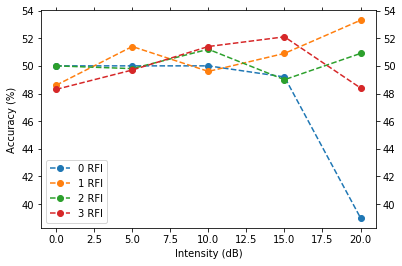

In [99]:
db = [0, 5, 10, 15, 20]
plt.plot(db, rfi[0], 'o--', label='0 RFI')
plt.plot(db, rfi[1], 'o--', label='1 RFI')
plt.plot(db, rfi[2], 'o--', label='2 RFI')
plt.plot(db, rfi[3], 'o--', label='3 RFI')

plt.legend()
plt.xlabel('Intensity (dB)')
plt.ylabel('Accuracy (%)')
plt.tick_params(top=True, right=True, labelright=True)
plt.show()

In [130]:
fil = Waterfall('placeholder.fil')

In [131]:
fil.data.shape

(32, 1, 1024)

In [135]:
fil.data = np.load('/datax/scratch/bbrzycki/training/training1/test/frame_2rfi_1sig_10db_0000.npy')


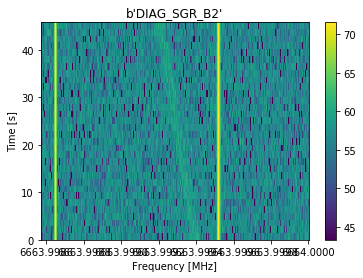

In [136]:
fil.plot_waterfall()

In [137]:
fil.write_to_fil('frame_2rfi_1sig_10db_0000.fil')

blimpy.waterfall INFO     Conversion time: 0.01sec


In [168]:
rfi_num = 2
sig_num = 1
sig_db = 10
index = 0

fn = '/datax/scratch/bbrzycki/training/training1/test/frame_%drfi_%dsig_%02ddb_%04d.npy' % (rfi_num, sig_num, sig_db, index)
data = np.load(fn)

fil = Waterfall('placeholder.fil')
fil.data = data

all_info[fn]



('/datax/scratch/bbrzycki/training/training1/test/frame_2rfi_1sig_10db_0000.npy',
 '1',
 '10',
 '435',
 '-4.149391254842517e-06',
 '1.6643641646271007e-05',
 '2',
 '25',
 '[345, 968]',
 '[4.325452013944538e-06, 3.456193199441902e-06]')

In [157]:
fil.write_to_hdf5('/datax/scratch/bbrzycki/turbo/frame_2rfi_1sig_10db_0000.h5')

blimpy.waterfall WARNING  Warning: bitshuffle not found. No compression applied.


IndexError: Index out of range

In [ ]:
plt.imshow(data, aspect='auto')
plt.colorbar()
plt.show()

In [235]:
fil.header[b'source_name'] = '2rfi_1sig_10db_0000'

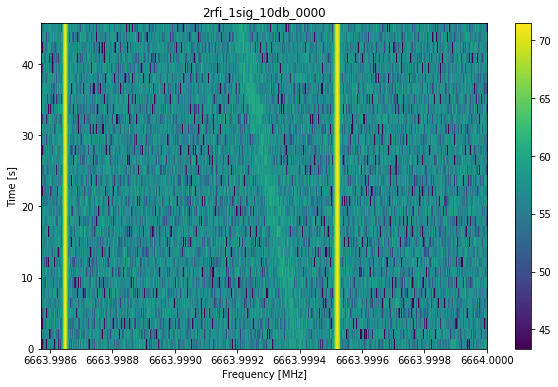

In [236]:
fig = plt.figure(figsize=(10, 6))
fil.plot_waterfall()
plt.show()

In [159]:
# HACKING TURBOSETI TO WORK IN PYTHON

import numpy as np
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from blimpy import read_header, Waterfall, Filterbank

import matplotlib.pyplot as plt

import sys, os, glob
sys.path.append("../")
import setigen as stg

# import edited version of turbo_seti
sys.path.insert(1,'/home/bryanb/turbo_seti/')
from turbo_seti.findoppler.findopp import FinDoppler

######

split_fns = ['frame_2rfi_1sig_10db_0000.fil']

######

# create a file handler
handler = logging.FileHandler('turboseti.log')
handler.setLevel(logging.INFO)

# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# add the handlers to the logger
logger.addHandler(handler)

# This is a hack... necessary to make turbo_seti work?
obs_info = {}
obs_info['pulsar'] = 0  # Bool if pulsar detection.
obs_info['pulsar_found'] = 0  # Bool if pulsar detection.
obs_info['pulsar_dm'] = 0.0  # Pulsar expected DM.
obs_info['pulsar_snr'] = 0.0 # SNR
obs_info['pulsar_stats'] = np.zeros(6)
obs_info['RFI_level'] = 0.0
obs_info['Mean_SEFD'] = 0.0
obs_info['psrflux_Sens'] = 0.0
obs_info['SEFDs_val'] = [0.0]
obs_info['SEFDs_freq'] = [0.0]
obs_info['SEFDs_freq_up'] = [0.0]

for fil_fn in split_fns:
    # print('Searching 10: %s' % fn)
    logger.info('Searching 10: %s' % fil_fn)
    find_seti_event = FinDoppler(fil_fn, max_drift=40.0, snr=5.0, out_dir='/datax/scratch/bbrzycki/turbo', obs_info=obs_info)
    find_seti_event.search()
    # print('Finishing searching %s' % fn)
    logger.info('Finishing searching %s' % fn)

print('Finished searching everything with turbo_seti!')

######

# print('Starting dataframe search')
logger.info('Starting dataframe search')
# Sort files with and without Doppler drifted hits
# no_hits = []
# hits_no_doppler = []
# hits_with_doppler = []
all_hits = []

df = pd.DataFrame()
for fil_fn in split_fns:
    head, tail = os.path.split(fil_fn)
    
    csv = '/datax/scratch/bbrzycki/turbo/' + tail[:-4] + '.dat'
    
    # print('On %s' % csv)
    names = ['Top_Hit_#', 'Drift_Rate', 'SNR', 'Uncorrected_Frequency', 'Corrected_Frequency', 'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 'Full_number_of_hits']
    dataframe = pd.read_csv(csv, delim_whitespace=True, comment='#', names=names)
    
#     if len(dataframe) == 0:
#         no_hits.append(i)
#     elif all(dataframe['Drift_Rate'] == 0.0):
#         hits_no_doppler.append(i)
#     else:
#         hits_with_doppler.append(i)
    all_hits.append(fil_fn)
    print(dataframe)
# print('# no hits: %s' % len(no_hits))
# print('# hits no doppler: %s' % len(hits_no_doppler))
# print('# hits with doppler: %s' % len(hits_with_doppler))

# with open(output_dir+'search_10/no_hits.txt', 'w') as no_hits_file:
#     for index in no_hits:
#         no_hits_file.write('%s\n' % index)
# with open(output_dir+'search_10/hits_no_doppler.txt', 'w') as hits_no_doppler_file:
#     for index in hits_no_doppler:
#         hits_no_doppler_file.write('%s\n' % index)
# with open(output_dir+'search_10/hits_with_doppler.txt', 'w') as hits_with_doppler_file:
#     for index in hits_with_doppler:
#         hits_with_doppler_file.write('%s\n' % index)
        
# print('Finished writing out to file')
# logger.info('Finished writing out to file')



__main__        INFO     Searching 10: frame_2rfi_1sig_10db_0000.fil
turbo_seti.findoppler.data_handler INFO     File .fil detected. Attempting to create .h5 file in current directory...
blimpy.waterfall WARNING  Warning: bitshuffle not found. No compression applied.
blimpy.waterfall INFO     Conversion time: 0.04sec
blimpy.file_wrapper INFO     Skipping loading data ...
blimpy.file_wrapper INFO     Skipping loading data ...
turbo_seti.findoppler.findopp INFO     {b'DIMENSION_LABELS': array([b'frequency', b'feed_id', b'time'], dtype=object), b'az_start': 0.0, b'data_type': 1, b'fch1': 6663.99999987334, b'foff': -1.3969838619232178e-06, b'ibeam': -1, b'machine_id': 20, b'nbeams': 1, b'nbits': 32, b'nchans': 1024, b'nifs': 1, b'rawdatafile': b'blc13_guppi_58465_61957_DIAG_SGR_B2_0066.0000.raw', b'source_name': b'DIAG_SGR_B2', b'src_dej': <Angle -28.3831 deg>, b'src_raj': <Angle 17.7875 hourangle>, b'telescope_id': 6, b'tsamp': 1.431655765333332, b'tstart': 58465.717094907406, b'za_start'

In [160]:
dataframe

,Top_Hit_#,Drift_Rate,SNR,Uncorrected_Frequency,Corrected_Frequency,Index,freq_start,freq_end,SEFD,SEFD_freq,Coarse_Channel_Number,Full_number_of_hits
0,1,0.0,299.878473,6663.999518,6663.999518,345,6663.999839,6663.999199,0.0,0.0,1,13699
1,2,0.0,297.333871,6663.998648,6663.998648,968,6663.998969,6663.998571,0.0,0.0,1,13699
2,1,0.0,299.878473,6663.999518,6663.999518,345,6664.000000,6663.998571,0.0,0.0,1,1257727
3,1,0.0,299.878473,6663.999518,6663.999518,345,6664.000000,6663.998571,0.0,0.0,1,195915
4,1,0.0,299.878473,6663.999518,6663.999518,345,6664.000000,6663.998571,0.0,0.0,1,13699
5,1,0.0,299.878473,6663.999518,6663.999518,345,6663.999839,6663.999199,0.0,0.0,1,13699
6,2,0.0,297.333871,6663.998648,6663.998648,968,6663.998969,6663.998571,0.0,0.0,1,13699
7,1,0.0,299.878473,6663.999518,6663.999518,345,6663.999839,6663.999199,0.0,0.0,1,193504
8,2,0.0,297.333871,6663.998648,6663.998648,968,6663.998969,6663.998571,0.0,0.0,1,193504
9,1,0.0,299.878473,6663.999518,6663.999518,345,6664.000000,6663.998571,0.0,0.0,1,928288


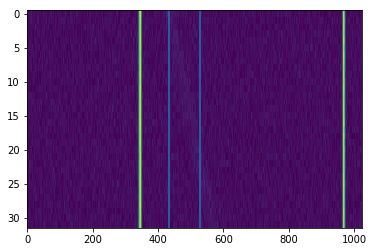

In [178]:
plt.imshow(data, aspect='auto')
plt.axvline(x=435)
plt.axvline(x=530)

In [170]:
all_info[fn]

('/datax/scratch/bbrzycki/training/training1/test/frame_2rfi_1sig_10db_0000.npy',
 '1',
 '10',
 '435',
 '-4.149391254842517e-06',
 '1.6643641646271007e-05',
 '2',
 '25',
 '[345, 968]',
 '[4.325452013944538e-06, 3.456193199441902e-06]')

In [171]:
fil.header

{b'machine_id': 20,
 b'telescope_id': 6,
 b'src_raj': <Angle 17.7875 hourangle>,
 b'src_dej': <Angle -28.3831 deg>,
 b'az_start': 0.0,
 b'za_start': 0.0,
 b'data_type': 1,
 b'fch1': 6663.99999987334,
 b'foff': -1.3969838619232178e-06,
 b'nchans': 1024,
 b'nbeams': 1,
 b'ibeam': -1,
 b'nbits': 32,
 b'tstart': 58465.717094907406,
 b'tsamp': 1.431655765333332,
 b'nifs': 1,
 b'source_name': b'DIAG_SGR_B2',
 b'rawdatafile': b'blc13_guppi_58465_61957_DIAG_SGR_B2_0066.0000.raw'}

In [172]:
-4.149391254842517e-06 / -1.3969838619232178e-06

2.9702499563095017

In [174]:
32*2.9702499563095017 + 435

530.047998601904

In [195]:
-4.149391254842517e-06 * 1.431655765333332 * 32 / -1.3969838619232178e-06 + 435

571.0760151818104

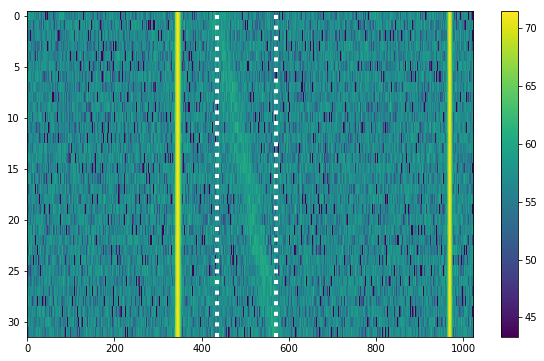

In [204]:
fig = plt.figure(figsize=(10,6))
plt.imshow(10*np.log10(data), aspect='auto')
plt.axvline(x=435, c='w', linestyle=':', linewidth=4)
plt.axvline(x=571.076, c='w', linestyle=':', linewidth=4)
# plt.plot(ts * -4.149391254842517e-06 / -1.3969838619232178e-06 + 435, range(len(ts)), linewidth=2, linestyle='--', c='blue')
plt.colorbar()
plt.show()

In [205]:
-4.149391254842517e-06 * 1.431655765333332 * 32 / -1.3969838619232178e-06

136.07601518181042

In [206]:
len(fs)

1024

In [208]:
data.shape

(32, 1024)

In [209]:
1024-136

888

In [216]:
shifted = np.zeros((32, 888))
shift = 136 / 32
print(shift)
for row in range(32):
    shifted[row, :] = data[row, int(row * shift):int(row * shift + 888)]

4.25


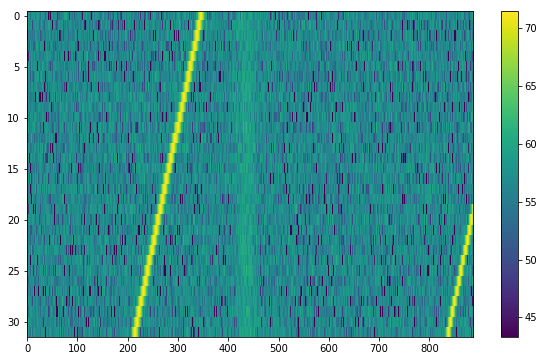

In [217]:
fig = plt.figure(figsize=(10,6))
plt.imshow(10*np.log10(shifted), aspect='auto')
plt.colorbar()
plt.show()

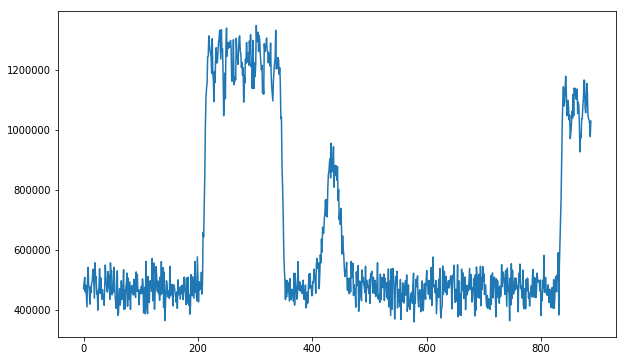

In [230]:
fig = plt.figure(figsize=(10,6))
spectrum = np.mean(shifted, axis=0)
plt.plot(spectrum)
plt.show()

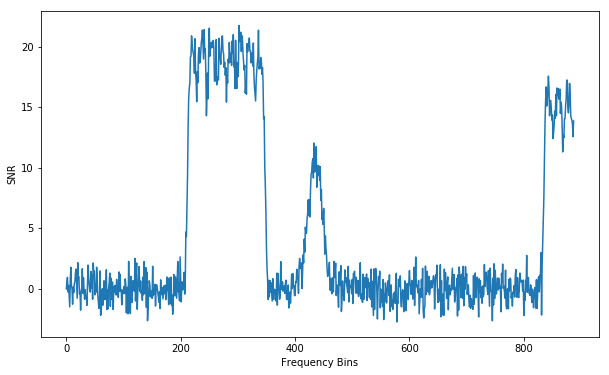

In [233]:
fig = plt.figure(figsize=(10,6))
plt.plot((spectrum - np.mean(spectrum[:100]))/np.std(spectrum[:100]))
plt.ylabel('SNR')
plt.xlabel('Frequency Bins')
plt.show()

In [34]:
# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import multi_gpu_model

import keras
import tensorflow as tf

import numpy as np
import os, sys, errno

import csv
import codecs
import pickle

from training_classes import DataGenerator

def custom_loss(y_true, y_pred):
    ts, td, tl = y_true
    ps, pd, pl = y_pred

# dimensions of our images.
img_width, img_height = 32, 1024
epochs = 100

dir_name = '/datax/scratch/bbrzycki/training/training1/'
train_csv_fn = dir_name + 'train/train_labels.csv'
# validation_csv_fn = dir_name + 'train/validation_labels.csv'
model_fn = dir_name + 'models/model3.h5'
history_fn = dir_name + 'models/model3_history'

total_image_num = 5000*4*2*5
train_num = int(total_image_num * 0.8)
validation_num = total_image_num - train_num

epochs = 50
batch_size = 256

# Parameters
params = {'dim': (32, 1024),
          'batch_size': 64,
          'n_channels': 1,
          'shuffle': True}

# Datasets
partition = {'train' : [], 'validation' : []}
labels = {}

# max_drift = 31.225e-6

with open(train_csv_fn, 'r') as f:
    reader = csv.reader(x.replace('\0', '') for x in f)
    for i, row in enumerate(reader):
        output_path, sig_num, sig_db, start_index, drift_rate, line_width, rfi_num, rfi_db, rfi_indices, rfi_widths = row
        label = int(sig_num) + int(rfi_num)
        if i < train_num:
            partition['train'].append(output_path)
        else:
            partition['validation'].append(output_path)
        labels[output_path] = label
 
# labels = {key: (value / max_drift) for (key, value) in labels.items()}
    
# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit_generator(generator=training_generator,
                    steps_per_epoch=train_num // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_num // batch_size,
                    callbacks=[keras.callbacks.ModelCheckpoint(model_fn, monitor='loss', verbose=0, save_best_only=True, mode='auto'), keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001), keras.callbacks.EarlyStopping(monitor='loss', patience=10,verbose=0, mode='auto')])

model.save_weights(model_fn)
with open(history_fn, 'wb') as f:
    pickle.dump(history.history, f)

model.summary()


tensorflow      WARNING  From /home/bryanb/miniconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3363: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
tensorflow      WARNING  From /home/bryanb/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
625/625 [==============================] - 54s 87ms/step - loss: 0.4285 - acc: 0.5595 - val_loss: 1.3537 - val_acc: 0.2530
Epoch 2/50
625/625 [==============================] - 47s 75ms/step - loss: 0.3006 - acc: 0.6232 - val_loss: 0.6942 - val_acc: 0.4002
Epoch 3/50
625/625 [==============================] - 57s 91ms/step - loss: 0.2763 - acc: 0.6511 - 

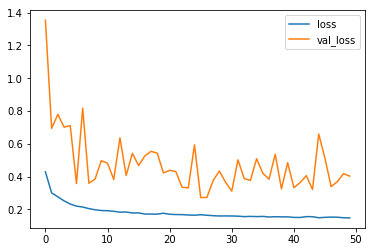

In [35]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [46]:
X = np.load('/datax/scratch/bbrzycki/training/training1/test/frame_2rfi_1sig_20db_0000.npy').reshape((1, 32, 1024, 1))
X -= np.mean(X)
X /= np.std(X)
    

In [47]:
model.predict(X)

array([[2.853732]], dtype=float32)

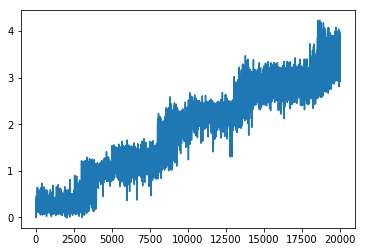

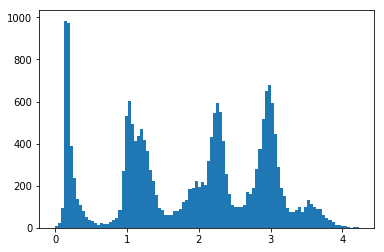

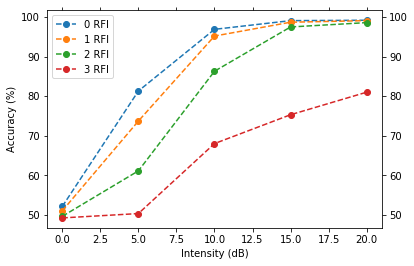

In [60]:
predictions = []
labels = []

rfi = np.zeros((4, 5))
for input_fn in inputs:
    sig_num, sig_db, rfi_num, rfi_db = info[input_fn]
    
    X = np.load(input_fn).reshape((1, 32, 1024, 1))
    X -= np.mean(X)
    X /= np.std(X)
    prediction = model.predict(X)[0][0]
    
    predictions.append(prediction)
    
    label = int(sig_num) + int(rfi_num)
    labels.append(label)
        
    if label == round(prediction):
        rfi[int(rfi_num), int(sig_db) // 5] += 1
#     print(int(rfi_num), int(sig_db) // 5, int(sig_num) * predicted_sig_num)
    
rfi /= 1000

# for percent
rfi *= 100


predictions = np.array(predictions)
labels = np.array(labels)

plt.plot(predictions)
plt.show()

plt.hist(predictions, bins=100)
plt.show()


db = [0, 5, 10, 15, 20]
plt.plot(db, rfi[0], 'o--', label='0 RFI')
plt.plot(db, rfi[1], 'o--', label='1 RFI')
plt.plot(db, rfi[2], 'o--', label='2 RFI')
plt.plot(db, rfi[3], 'o--', label='3 RFI')

plt.legend()
plt.xlabel('Intensity (dB)')
plt.ylabel('Accuracy (%)')
plt.tick_params(top=True, right=True, labelright=True)
plt.show()

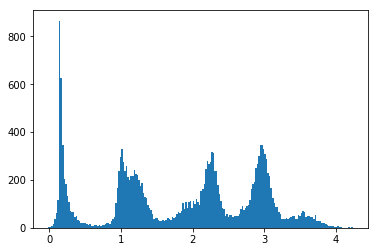

In [50]:
plt.hist(predictions, bins=200)
plt.show()

In [55]:
np.round(predictions)

array([0., 0., 0., ..., 4., 3., 4.], dtype=float32)

In [56]:
labels

array([0, 0, 0, ..., 4, 4, 4])

In [58]:
np.round(predictions) == labels

array([ True,  True,  True, ...,  True, False,  True])

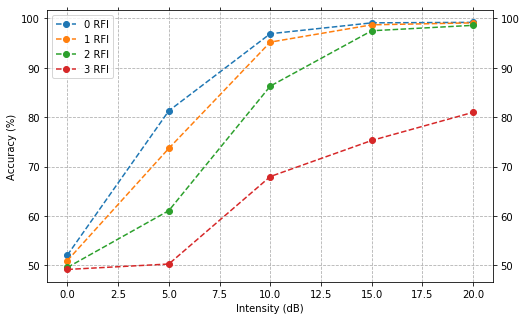

In [83]:
db = [0, 5, 10, 15, 20]
fig = plt.figure(figsize=(8,5))
plt.plot(db, rfi[0], 'o--', label='0 RFI')
plt.plot(db, rfi[1], 'o--', label='1 RFI')
plt.plot(db, rfi[2], 'o--', label='2 RFI')
plt.plot(db, rfi[3], 'o--', label='3 RFI')

plt.legend()
plt.xlabel('Intensity (dB)')
plt.ylabel('Accuracy (%)')
plt.tick_params(top=True, right=True, which='both', labelright=True, grid_linestyle='--')
plt.grid()
plt.show()

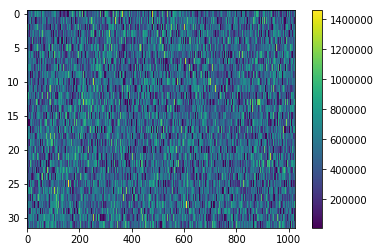

1.1272831
Prediction:  1.0
Truth:  1


In [183]:
tsamp = 1.4316557653333333
fch1 = 6000.464843051508
df = -1.3969838619232178e-06

fchans = 1024
tchans = 32
fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

#################################################################
def choose_from_dist(dist, shape):
    return dist[np.random.randint(0, len(dist), shape)]

def make_normal(means_dist, stds_dist, mins_dist, shape):
    means = choose_from_dist(means_dist, shape)
    stds = choose_from_dist(stds_dist, shape)
    mins = choose_from_dist(mins_dist, shape)
    means = np.maximum(means, stds)
    return means, stds, mins

def generate_frame(sig_num=True,
                   sig_db=10,
                   rfi_num=0,
                   rfi_db=25,
                   means_dist=None,
                   stds_dist=None,
                   mins_dist=None,
                    **kwargs):
    
    noise_mean, noise_std, noise_min = make_normal(means_dist, stds_dist, mins_dist, 1)
    noise_frame = np.maximum(np.random.normal(noise_mean, noise_std, [tchans, fchans]), noise_min)
    frame = noise_frame
    
    rfi_indices = []
    rfi_widths = []
    for i in range(rfi_num):
        rfi_snr = np.power(10, rfi_db / 10)
        rfi_level = noise_std * rfi_snr / np.sqrt(tchans)
        rfi_start_index = np.random.randint(0, fchans)
        rfi_indices.append(rfi_start_index)
        rfi_line_width = np.random.uniform(1e-6, 30e-6)
        rfi_widths.append(rfi_line_width)
        rfi_signal = stg.generate(ts,
                                  fs,
                                  stg.constant_path(f_start=fs[rfi_start_index], drift_rate=0),
                                  stg.constant_t_profile(level=rfi_level),
                                  stg.gaussian_f_profile(width=rfi_line_width),
                                  stg.constant_bp_profile(level=1.0))
        frame += rfi_signal

    if sig_num == 1:
        snr = np.power(10, sig_db / 10)
        level = noise_std * snr / np.sqrt(tchans)
        start_index = np.random.randint(0, fchans)
        drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                                       (fchans-1-start_index)*df/(tsamp*tchans))
        line_width = np.random.uniform(1e-6, 30e-6)
        signal = stg.generate(ts,
                              fs,
                              stg.constant_path(f_start=fs[start_index], drift_rate=drift_rate),
                              stg.constant_t_profile(level=level),
                              stg.gaussian_f_profile(width=line_width),
                              stg.constant_bp_profile(level=1.0))
        frame += signal
    else:
        level = 0
        start_index = -1
        drift_rate = 0
        line_width = 0
    
    return frame, [sig_num, sig_db, start_index, drift_rate, line_width, rfi_num, rfi_db, rfi_indices, rfi_widths]

real_noise = np.load('real_noise_dists.npy')
means_dist = real_noise[:,0]
stds_dist = real_noise[:,1]
mins_dist = real_noise[:,2]

sig_num=1
sig_db=5
rfi_num=0
rfi_db=25

frame, [sig_num, sig_db, start_index, drift_rate, line_width, rfi_num, rfi_db, rfi_indices, rfi_widths] = generate_frame(
               sig_num=sig_num,
               sig_db=sig_db,
               rfi_num=rfi_num,
               rfi_db=rfi_db,
               means_dist=means_dist,
               stds_dist=stds_dist,
               mins_dist=mins_dist)

plt.imshow(frame, aspect='auto')
plt.colorbar()
plt.show()

X = np.reshape(np.copy(frame), (1, 32, 1024, 1))
X -= np.mean(X)
X /= np.std(X)

prediction = model.predict(X)[0][0]
print(prediction)
print('Prediction: ', round(prediction))
print('Truth: ', sig_num + rfi_num)


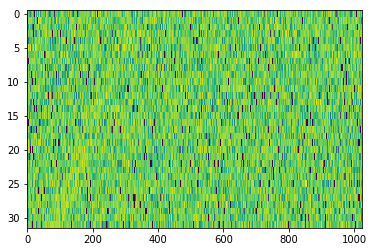

In [184]:
plt.imshow(10*np.log10(frame), aspect='auto')
plt.show()

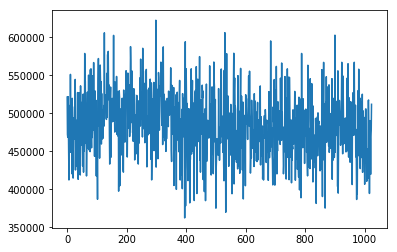

In [185]:
plt.plot(np.mean(frame, axis=0))
plt.show()

In [143]:
frame

array([[-0.32552699, -0.36883457, -0.34830586, ..., -0.19098248,
        -0.25621723, -0.34140358],
       [-0.22076065, -0.29208351, -0.26322767, ..., -0.1526769 ,
        -0.17916887, -0.1929425 ],
       [-0.38230693, -0.36029462, -0.31430109, ..., -0.14084007,
        -0.25422156, -0.21301795],
       ...,
       [-0.39967346, -0.19867108, -0.3778467 , ..., -0.30974821,
        -0.11670012, -0.2697063 ],
       [-0.3294149 , -0.37843309, -0.396524  , ..., -0.18846673,
        -0.25127429, -0.32575221],
       [-0.31594469, -0.35748389, -0.29589419, ..., -0.22108872,
        -0.23952823, -0.21301813]])

In [156]:
a = np.array([1])
b = np.copy(a)
b[0] = 2
a, b

(array([1]), array([2]))

In [205]:
# Design model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('tanh'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (1, 1)))
model.add(Activation('tanh'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (1, 1)))
model.add(Activation('tanh'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('tanh'))

model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 30, 1022, 32)      320       
_________________________________________________________________
activation_100 (Activation)  (None, 30, 1022, 32)      0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 28, 1020, 32)      9248      
_________________________________________________________________
activation_101 (Activation)  (None, 28, 1020, 32)      0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 14, 510, 32)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 14, 510, 32)       1056      
_________________________________________________________________
activation_102 (Activation)  (None, 14, 510, 32)       0         
__________